<a href="https://colab.research.google.com/github/aadomingos/energyUsageInsights/blob/master/tempNormalizedUsage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

To start, set up the notebook with the basic required libraries and to access the data.

In [1]:
# python imports
import pandas as pd
import numpy as np
import datetime
import pytz
import json

# graphic imports
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# mount your Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# write path to your Google Drive folder that contains the data
usagePath = '/content/drive/My Drive/Colab Notebooks/data/SRP/hourlyUsage.csv'

# Import and Setup Data

Import the data.

In [4]:
# read usage data into pandas dataframe
usageData_df = pd.read_csv(usagePath)

# get info about the dataframe
print(usageData_df.info())

# check the first few rows of the dataframe
print(usageData_df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9528 entries, 0 to 9527
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Usage date  9528 non-null   object 
 1   Interval    9528 non-null   object 
 2   Total kWh   9528 non-null   float64
dtypes: float64(1), object(2)
memory usage: 223.4+ KB
None
  Usage date Interval  Total kWh
0   7/1/2019  12:0 am        1.1
1   7/1/2019   1:0 am        0.4
2   7/1/2019   2:0 am        1.0
3   7/1/2019   3:0 am        0.9
4   7/1/2019   4:0 am        0.3


Transform the dataframe to be later used in eeMeter.

In [5]:
# combine the usage date and interval columns for eeMeter
usageData_df['start'] = usageData_df['Usage date'] + ' ' + usageData_df['Interval']

# convert the concatenated column to a datetime object
usageData_df['start'] = pd.to_datetime(usageData_df['start'], infer_datetime_format=True)

# create a datetime index for the dataframe from the datetime column and resample to set the frequency
usageData_df = usageData_df.set_index(pd.DatetimeIndex(usageData_df['start'], tz='America/Phoenix'))\
    .resample('H').mean()

# set the timezone to UTC
usageData_df = usageData_df.tz_convert('UTC')

In [6]:
# change column name for eeMeter (to be used later)
usageData_df.rename(columns={'Total kWh':'value'}, inplace=True)

# Import Weather From eeWeather

Install and import eeWeather.

In [7]:
# install eeWeather
!pip install eeweather

     |████████████████████████████████| 4.1MB 2.7MB/s 
     |████████████████████████████████| 10.9MB 29.6MB/s 


In [8]:
# import eeWeather
import eeweather

Find weather for the energy meter zip code.

In [9]:
# convert zip code/ZCTA to coordinates
lat, lng = eeweather.zcta_to_lat_long('85008')

In [10]:
# rank stations by distance from zip code/ZCTA
rankedStations_df = eeweather.rank_stations(lat, lng)
rankedStations_df.head(10)

,rank,distance_meters,latitude,longitude,iecc_climate_zone,iecc_moisture_regime,ba_climate_zone,ca_climate_zone,rough_quality,elevation,state,tmy3_class,is_tmy3,is_cz2010,difference_elevation_meters
usaf_id,,,,,,,,,,,,,,,
722780,1,4231.377100,33.428,-112.004,2,B,Hot-Dry,None,high,337.4,AZ,I,True,False,None
722789,2,19058.646831,33.623,-111.911,2,B,Hot-Dry,None,high,449.0,AZ,II,True,False,None
722783,3,23592.962364,33.467,-111.733,2,B,Hot-Dry,None,low,420.6,AZ,None,False,False,None
722784,4,26443.924819,33.688,-112.082,2,B,Hot-Dry,None,high,443.5,AZ,II,True,False,None
722749,5,26943.183693,33.269,-111.813,2,B,Hot-Dry,None,medium,378.9,AZ,None,False,False,None
722787,6,29502.363911,33.527,-112.295,2,B,Hot-Dry,None,medium,324.9,AZ,None,False,False,None
722786,7,34832.708252,33.300,-111.667,2,B,Hot-Dry,None,high,421.2,AZ,None,False,False,None
722785,8,36615.287081,33.550,-112.367,2,B,Hot-Dry,None,medium,330.7,AZ,II,True,False,None
722788,9,37201.220560,33.417,-112.383,2,B,Hot-Dry,None,medium,295.1,AZ,None,False,False,None


In [11]:
# select station with rank 1
selectedStation, warnings = eeweather.select_station(rankedStations_df)

# print weather station ID and warnings
print('This is the selected weather station: ISD', selectedStation)
print('These are the warnings for this station:', warnings)

This is the selected weather station: ISD 722780
These are the warnings for this station: []


In [12]:
# find only high quality weather stations that match the station above
highQualityStations_df = eeweather.rank_stations(
    lat, lng,
    match_iecc_climate_zone=True,
    match_iecc_moisture_regime=True,
    match_ba_climate_zone=True,
    match_ca_climate_zone=True,
    minimum_quality='high',  # find stations with reported high frequency data
    is_tmy3=True,            # find stations with TMY3 normal year data
)

highQualityStations_df.head()

,rank,distance_meters,latitude,longitude,iecc_climate_zone,iecc_moisture_regime,ba_climate_zone,ca_climate_zone,rough_quality,elevation,state,tmy3_class,is_tmy3,is_cz2010,difference_elevation_meters
usaf_id,,,,,,,,,,,,,,,
722780,1,4231.377100,33.428,-112.004,2,B,Hot-Dry,None,high,337.4,AZ,I,True,False,None
722789,2,19058.646831,33.623,-111.911,2,B,Hot-Dry,None,high,449.0,AZ,II,True,False,None
722784,3,26443.924819,33.688,-112.082,2,B,Hot-Dry,None,high,443.5,AZ,II,True,False,None
722740,4,176549.590786,32.131,-110.955,2,B,Hot-Dry,None,high,776.9,AZ,I,True,False,None


In [13]:
# this is the timezone where this energy usage originated
phoenix = pytz.timezone('America/Phoenix')

# format for timestamps
fmt = '%Y-%m-%d %H:%M %Z%z'

# start date for weather data (start date for energy usage)
start_date = datetime.datetime(2019, 7, 1, 0, 0, tzinfo=phoenix)
start_date = start_date.astimezone(pytz.timezone('UTC'))

# end date for weather data (end date for energy usage)
end_date = datetime.datetime(2020, 7, 31, 23, 0, tzinfo=phoenix)
end_date = end_date.astimezone(pytz.timezone('UTC'))

# find the weather station with the highest coverage
station, warnings = eeweather.select_station(
    highQualityStations_df,
    coverage_range=(start_date, end_date),
    min_fraction_coverage=0.99,
    rank=1
)

print('weather statioin ID ', station)
print('start date ', start_date.strftime(fmt))
print('end date ', end_date.strftime(fmt))

weather statioin ID  722780
start date  2019-07-01 07:28 UTC+0000
end date  2020-08-01 06:28 UTC+0000


In [14]:
# check weather station meta-data
highQualityStations_df.loc[station.usaf_id]
# print(json.dumps(station.json(), indent=2))

rank                                 1
distance_meters                4231.38
latitude                        33.428
longitude                     -112.004
iecc_climate_zone                    2
iecc_moisture_regime                 B
ba_climate_zone                Hot-Dry
ca_climate_zone                   None
rough_quality                     high
elevation                        337.4
state                               AZ
tmy3_class                           I
is_tmy3                           True
is_cz2010                        False
difference_elevation_meters       None
Name: 722780, dtype: object

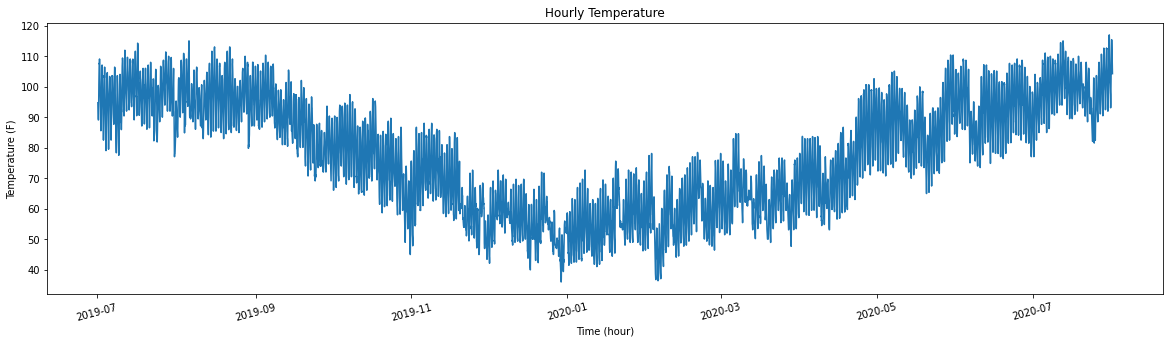

In [15]:
# get temperature from weather station
temp_C = station.load_isd_hourly_temp_data(start_date, end_date)

# convert from Celsius to Fahrenheit
tempF = temp_C[0].mul(1.8).add(32)
tempF.index.rename('dt', inplace=True)
tempF.rename('tempF', inplace=True)

# plot temperature for visualization
plt.figure(figsize=(20,5))
sns.lineplot(data=tempF)
plt.xticks(rotation=15)
plt.xlabel('Time (hour)')
plt.ylabel('Temperature (F)')
plt.title('Hourly Temperature')
plt.show()

# Import eeMeter

In [31]:
# install eemeter
!pip install git+https://github.com/aadomingos/eemeter/

  Cloning https://github.com/aadomingos/eemeter/ to /tmp/pip-req-build-e28qn81i
  Running command git clone -q https://github.com/aadomingos/eemeter/ /tmp/pip-req-build-e28qn81i
  Created wheel for eemeter: filename=eemeter-2.9.2-cp36-none-any.whl size=583129 sha256=5334cb984ae3613b4da50ef133e456d8989d971466262c2c30fc97a838ef6bba
  Stored in directory: /tmp/pip-ephem-wheel-cache-kvp3kgfy/wheels/47/e7/fa/462b7c9d9f48edfa485ac1cdc92b131aec217332bb9e39a0de
Successfully built eemeter


In [30]:
# import eeMeter
import eemeter-2.9.2

SyntaxError: ignored

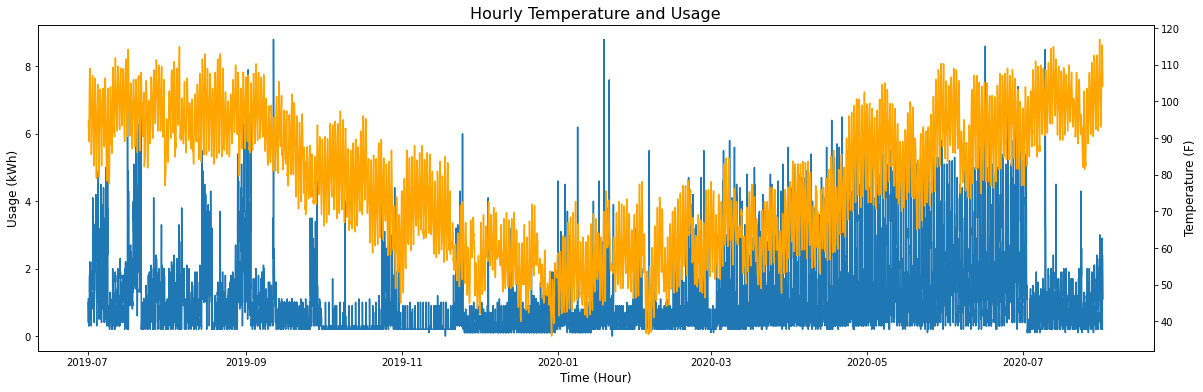

In [32]:
# # visualizing energy and temperature usage
# eemeter.plot_time_series(usageData_df, tempF, figsize=(16, 4))

# create first y-axis for usage graph
fig, ax1 = plt.subplots(figsize=(20,6))
g = sns.lineplot(x=usageData_df.index, y='value', data=usageData_df, ax=ax1)

# set the axis labels
ax1.set_title('Hourly Temperature and Usage', fontsize=16)
ax1.set_ylabel('Usage (kWh)', fontsize=12)
ax1.set_xlabel('Time (Hour)', fontsize=12)

# create a second y-axis for temperature graph
color = 'orange'
ax2 = ax1.twinx()
ax2 = sns.lineplot(data=tempF, color=color)
ax2.set_ylabel('Temperature (F)', fontsize=12)

# show graph
plt.show()

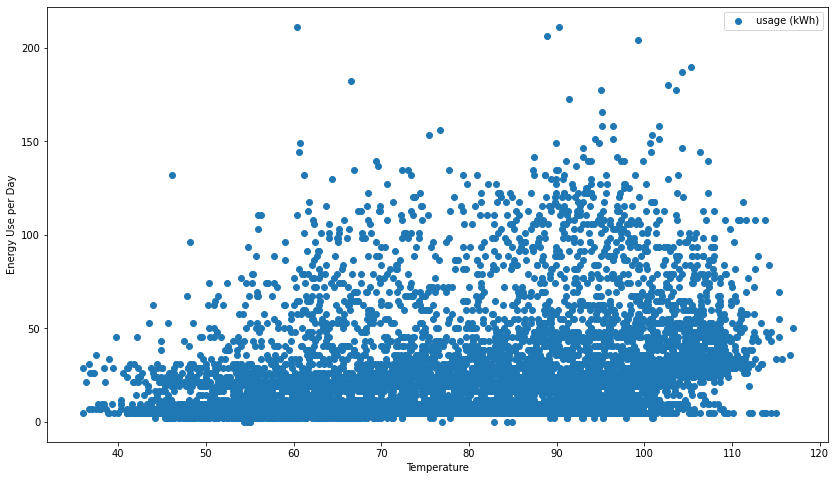

In [33]:
# display energy usage signature
ax = eemeter.plot_energy_signature(usageData_df, tempF, figsize=(14, 8))
ax.legend(labels=['usage (kWh)'])

In [20]:
# create a design matrix for occupancy and segmentation
preliminary_design_matrix = (
    eemeter.create_caltrack_hourly_preliminary_design_matrix(
        usageData_df, tempF,
    )
)

# preliminary design matrix
preliminary_design_matrix.head(5)

,meter_value,temperature_mean,cdd_65,hdd_50,n_hours_dropped,n_hours_kept,hour_of_week
start,,,,,,,
2019-07-01 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01 08:00:00+00:00,0.4,94.70660,29.70660,0.0,0.0,1.0,8
2019-07-01 09:00:00+00:00,1.0,93.32096,28.32096,0.0,0.0,1.0,9
2019-07-01 10:00:00+00:00,0.9,91.07816,26.07816,0.0,0.0,1.0,10
2019-07-01 11:00:00+00:00,0.3,89.39156,24.39156,0.0,0.0,1.0,11


In [21]:
# build 12 monthly models - each step from now on operates on each segment
segmentation = eemeter.segment_time_series(
    preliminary_design_matrix.index,
    'three_month_weighted'
)

In [22]:
# assign an occupancy status to each hour of the week (0-167)
occupancy_lookup = eemeter.estimate_hour_of_week_occupancy(
    preliminary_design_matrix,
    segmentation=segmentation,
)

occupancy_lookup.head(25)

,dec-jan-feb-weighted,jan-feb-mar-weighted,feb-mar-apr-weighted,mar-apr-may-weighted,apr-may-jun-weighted,may-jun-jul-weighted,jun-jul-aug-weighted,jul-aug-sep-weighted,aug-sep-oct-weighted,sep-oct-nov-weighted,oct-nov-dec-weighted,nov-dec-jan-weighted
hour_of_week,,,,,,,,,,,,
0,False,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,True,False,False,False,False,False,False,False
4,False,False,False,True,True,False,False,False,False,False,False,False
5,False,False,False,True,True,False,False,False,False,False,False,False
6,False,False,False,True,True,False,False,False,False,False,False,False
7,False,False,False,False,True,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False


In [23]:
# assign temperatures to bins
temperature_bins_hourly = eemeter.fit_temperature_bins(
    preliminary_design_matrix,
    segmentation=segmentation,
    default_bins=[40, 55, 65, 75, 85, 95, 105, 112],  # default
    min_temperature_count=10  # default
    )

temperature_bins_hourly

,dec-jan-feb-weighted,jan-feb-mar-weighted,feb-mar-apr-weighted,mar-apr-may-weighted,apr-may-jun-weighted,may-jun-jul-weighted,jun-jul-aug-weighted,jul-aug-sep-weighted,aug-sep-oct-weighted,sep-oct-nov-weighted,oct-nov-dec-weighted,nov-dec-jan-weighted
bin_endpoints,,,,,,,,,,,,
40,True,True,True,False,False,False,False,False,False,False,False,False
55,True,True,True,True,True,False,False,False,True,True,True,True
65,True,True,True,True,True,False,False,False,True,True,True,True
75,True,True,True,True,True,True,False,True,True,True,True,True
85,False,False,True,True,True,True,True,True,True,True,True,True
95,False,False,True,True,True,True,True,True,True,True,False,False
105,False,False,False,True,True,True,True,True,True,True,False,False
112,False,False,False,False,False,True,True,True,True,False,False,False


In [24]:
# build a design matrix for each monthly segment
segmented_design_matrices = (
    eemeter.create_caltrack_hourly_segmented_design_matrices(
        preliminary_design_matrix,
        segmentation,
        occupancy_lookup,
        temperature_bins_hourly,
    )
)

In [25]:
# build a CalTRACK hourly model
hourly_model = eemeter.fit_caltrack_hourly_model(
    segmented_design_matrices,
    occupancy_lookup,
    temperature_bins_hourly,
)

In [26]:
model_results = eemeter.CalTRACKHourlyModelResults(
        status="SUCCESS",
        method_name="caltrack_hourly",
        model=hourly_model,
    )

In [91]:
metered_savings_dataframe, error_bands = eemeter.metered_savings(
    hourly_model, usageData_df,
    tempF, with_disaggregated=True
)

TypeError: ignored

In [ ]:
segment_models = fit_model_segments(
        segmented_design_matrices, fit_caltrack_hourly_model_segment
    )
    all_warnings = [
        warning
        for segment_model in segment_models
        for warning in segment_model.warnings
    ]
    model = CalTRACKHourlyModel(segment_models, occupancy_lookup, temperature_bins)

    model_results = CalTRACKHourlyModelResults(
        status="SUCCEEDED",
        method_name="caltrack_hourly",
        warnings=all_warnings,
        model=model,
    )
    model_results.totals_metrics = {
        seg_model.segment_name: seg_model.totals_metrics for seg_model in segment_models
    }

In [52]:
model_results.totals_metrics = {
        seg_model.segment_name: seg_model.totals_metrics for seg_model in segment_models
    }

NameError: ignored

In [26]:
reporting_segmented_model_hourly = eemeter.fit_caltrack_hourly_model(
    segmented_design_matrices,
    occupancy_lookup,
    temperature_bins_hourly
)

In [27]:
annualized_savings_hourly, annualized_savings_warnings_hourly = eemeter.modeled_savings(
    baseline_model, reporting_segmented_model_hourly,
    usageData_df, tempF, with_disaggregated=True
)

TypeError: ignored

In [ ]:
# get a year of reporting period data
reporting_meter_data, warnings = eemeter.get_reporting_data(
    usageData_df)

# compute metered savings for the year of the reporting period we've selected
metered_savings_dataframe, error_bands = eemeter.metered_savings(
    baseline_model, usageData_df,
    tempF, with_disaggregated=True
)

# total metered savings
metered_savings_dataframe

TypeError: ignored

In [ ]:
metered_savings_hourly, error_bands = eemeter.metered_savings(
    baseline_model, usageData_df, tempF
)

TypeError: ignored

AttributeError: ignored

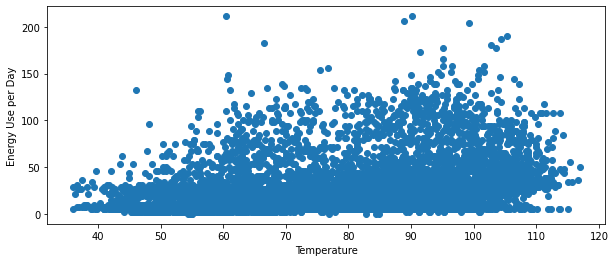

In [ ]:
ax = eemeter.plot_energy_signature(usageData_df, tempF)
baseline_model.plot(
    ax=ax, candidate_alpha=0.02, with_candidates=True, temp_range=(-5, 88)
)

In [ ]:
eemeter.compute_time_features

In [ ]:
# create daily baseline from hourly
baseline_meter_data_daily_from_hourly = eemeter.clean_caltrack_billing_daily_data(usageData_df, 'hourly')

# daily design matrix
design_matrix_daily = eemeter.create_caltrack_daily_design_matrix(
    baseline_meter_data_daily_from_hourly, tempF)

design_matrix_daily.head(5)

In [ ]:
design_matrix_daily.head(5)

,meter_value,temperature_not_null,temperature_null,temperature_mean,n_days_kept,n_days_dropped,cdd_30,cdd_31,cdd_32,cdd_33,cdd_34,cdd_35,cdd_36,cdd_37,cdd_38,cdd_39,cdd_40,cdd_41,cdd_42,cdd_43,cdd_44,cdd_45,cdd_46,cdd_47,cdd_48,cdd_49,cdd_50,cdd_51,cdd_52,cdd_53,cdd_54,cdd_55,cdd_56,cdd_57,cdd_58,cdd_59,cdd_60,cdd_61,cdd_62,cdd_63,...,hdd_51,hdd_52,hdd_53,hdd_54,hdd_55,hdd_56,hdd_57,hdd_58,hdd_59,hdd_60,hdd_61,hdd_62,hdd_63,hdd_64,hdd_65,hdd_66,hdd_67,hdd_68,hdd_69,hdd_70,hdd_71,hdd_72,hdd_73,hdd_74,hdd_75,hdd_76,hdd_77,hdd_78,hdd_79,hdd_80,hdd_81,hdd_82,hdd_83,hdd_84,hdd_85,hdd_86,hdd_87,hdd_88,hdd_89,hdd_90
2019-07-01 00:00:00+00:00,24.847059,16.0,0.0,98.335569,1.0,0.0,68.335569,67.335569,66.335569,65.335569,64.335569,63.335569,62.335569,61.335569,60.335569,59.335569,58.335569,57.335569,56.335569,55.335569,54.335569,53.335569,52.335569,51.335569,50.335569,49.335569,48.335569,47.335569,46.335569,45.335569,44.335569,43.335569,42.335569,41.335569,40.335569,39.335569,38.335569,37.335569,36.335569,35.335569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-02 00:00:00+00:00,31.500000,24.0,0.0,97.495565,1.0,0.0,67.495565,66.495565,65.495565,64.495565,63.495565,62.495565,61.495565,60.495565,59.495565,58.495565,57.495565,56.495565,55.495565,54.495565,53.495565,52.495565,51.495565,50.495565,49.495565,48.495565,47.495565,46.495565,45.495565,44.495565,43.495565,42.495565,41.495565,40.495565,39.495565,38.495565,37.495565,36.495565,35.495565,34.495565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-03 00:00:00+00:00,52.900000,24.0,0.0,95.273938,1.0,0.0,65.273938,64.273938,63.273938,62.273938,61.273938,60.273938,59.273938,58.273938,57.273938,56.273938,55.273938,54.273938,53.273938,52.273938,51.273938,50.273938,49.273938,48.273938,47.273938,46.273938,45.273938,44.273938,43.273938,42.273938,41.273938,40.273938,39.273938,38.273938,37.273938,36.273938,35.273938,34.273938,33.273938,32.273938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-04 00:00:00+00:00,43.600000,24.0,0.0,92.566198,1.0,0.0,62.566198,61.566198,60.566198,59.566198,58.566198,57.566198,56.566198,55.566198,54.566198,53.566198,52.566198,51.566198,50.566198,49.566198,48.566198,47.566198,46.566198,45.566198,44.566198,43.566198,42.566198,41.566198,40.566198,39.566198,38.566198,37.566198,36.566198,35.566198,34.566198,33.566198,32.566198,31.566198,30.566198,29.566198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-05 00:00:00+00:00,49.400000,24.0,0.0,93.608945,1.0,0.0,63.608945,62.608945,61.608945,60.608945,59.608945,58.608945,57.608945,56.608945,55.608945,54.608945,53.608945,52.608945,51.608945,50.608945,49.608945,48.608945,47.608945,46.608945,45.608945,44.608945,43.608945,42.608945,41.608945,40.608945,39.608945,38.608945,37.608945,36.608945,35.608945,34.608945,33.608945,32.608945,31.608945,30.608945,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

design_matrix_daily.index.min(), design_matrix_daily.index.max()

(Timestamp('2019-07-01 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2020-08-02 00:00:00+0000', tz='UTC', freq='D'))

In [ ]:
preliminary_design_matrix_hourly = eemeter.create_caltrack_hourly_preliminary_design_matrix(
    usageData_df, tempF)

In [ ]:
preliminary_design_matrix_hourly.head()


,meter_value,temperature_mean,cdd_65,hdd_50,n_hours_dropped,n_hours_kept,hour_of_week
start,,,,,,,
2019-07-01 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01 08:00:00+00:00,0.4,94.70660,29.70660,0.0,0.0,1.0,8
2019-07-01 09:00:00+00:00,1.0,93.32096,28.32096,0.0,0.0,1.0,9
2019-07-01 10:00:00+00:00,0.9,91.07816,26.07816,0.0,0.0,1.0,10
2019-07-01 11:00:00+00:00,0.3,89.39156,24.39156,0.0,0.0,1.0,11


In [ ]:
segmentation_hourly = eemeter.segment_time_series(
    preliminary_design_matrix_hourly.index,
    'three_month_weighted'
)
segmentation_hourly.head()

,dec-jan-feb-weighted,jan-feb-mar-weighted,feb-mar-apr-weighted,mar-apr-may-weighted,apr-may-jun-weighted,may-jun-jul-weighted,jun-jul-aug-weighted,jul-aug-sep-weighted,aug-sep-oct-weighted,sep-oct-nov-weighted,oct-nov-dec-weighted,nov-dec-jan-weighted
start,,,,,,,,,,,,
2019-07-01 07:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.5,0.0,0.0,0.0,0.0
2019-07-01 08:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.5,0.0,0.0,0.0,0.0
2019-07-01 09:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.5,0.0,0.0,0.0,0.0
2019-07-01 10:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.5,0.0,0.0,0.0,0.0
2019-07-01 11:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.5,0.0,0.0,0.0,0.0


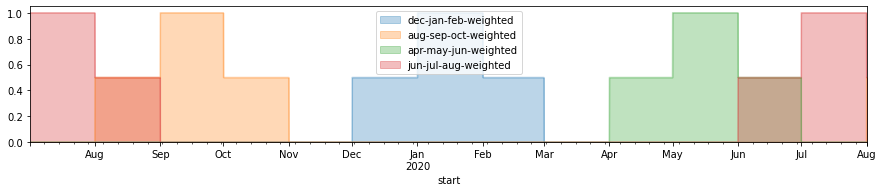

In [ ]:
# example segmentation weights
segmentation_hourly[[
    'dec-jan-feb-weighted',
    'aug-sep-oct-weighted',
    'apr-may-jun-weighted',
    'jun-jul-aug-weighted'
]].plot.area(stacked=False, alpha=0.3, figsize=(15, 2.5))

In [ ]:
occupancy_lookup_hourly = eemeter.estimate_hour_of_week_occupancy(
    preliminary_design_matrix_hourly,
    segmentation=segmentation_hourly,
    threshold=.65)


occupancy_lookup_hourly.tail()

,dec-jan-feb-weighted,jan-feb-mar-weighted,feb-mar-apr-weighted,mar-apr-may-weighted,apr-may-jun-weighted,may-jun-jul-weighted,jun-jul-aug-weighted,jul-aug-sep-weighted,aug-sep-oct-weighted,sep-oct-nov-weighted,oct-nov-dec-weighted,nov-dec-jan-weighted
hour_of_week,,,,,,,,,,,,
163,False,False,False,False,False,False,False,False,False,False,False,False
164,False,False,False,False,False,False,False,False,False,False,False,False
165,False,False,False,False,False,False,False,False,False,False,False,False
166,False,False,False,False,False,False,False,False,False,False,False,False
167,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
temperature_bins_hourly = eemeter.fit_temperature_bins(
    preliminary_design_matrix_hourly,
    segmentation=segmentation_hourly,
    default_bins=[40, 55, 65, 75, 85, 95, 105, 115],  # default
    min_temperature_count=10  # default
    )

temperature_bins_hourly

,dec-jan-feb-weighted,jan-feb-mar-weighted,feb-mar-apr-weighted,mar-apr-may-weighted,apr-may-jun-weighted,may-jun-jul-weighted,jun-jul-aug-weighted,jul-aug-sep-weighted,aug-sep-oct-weighted,sep-oct-nov-weighted,oct-nov-dec-weighted,nov-dec-jan-weighted
bin_endpoints,,,,,,,,,,,,
40,True,True,True,False,False,False,False,False,False,False,False,False
55,True,True,True,True,True,False,False,False,True,True,True,True
65,True,True,True,True,True,False,False,False,True,True,True,True
75,True,True,True,True,True,True,False,True,True,True,True,True
85,False,False,True,True,True,True,True,True,True,True,True,True
95,False,False,True,True,True,True,True,True,True,True,False,False
105,False,False,False,True,True,True,True,True,True,True,False,False
115,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
segmented_design_matrices_hourly = eemeter.create_caltrack_hourly_segmented_design_matrices(
    preliminary_design_matrix_hourly,
    segmentation_hourly,
    occupancy_lookup_hourly,
    temperature_bins_hourly,
)

In [ ]:
print(segmented_design_matrices_hourly.keys())
segmented_design_matrices_hourly['dec-jan-feb-weighted'].tail()

dict_keys(['dec-jan-feb-weighted', 'jan-feb-mar-weighted', 'feb-mar-apr-weighted', 'mar-apr-may-weighted', 'apr-may-jun-weighted', 'may-jun-jul-weighted', 'jun-jul-aug-weighted', 'jul-aug-sep-weighted', 'aug-sep-oct-weighted', 'sep-oct-nov-weighted', 'oct-nov-dec-weighted', 'nov-dec-jan-weighted'])


,meter_value,hour_of_week,occupancy,bin_0,bin_1,bin_2,bin_3,bin_4,weight
start,,,,,,,,,
2020-08-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
baseline_segmented_model_hourly = eemeter.fit_caltrack_hourly_model(
    segmented_design_matrices_hourly,
    occupancy_lookup_hourly,
    temperature_bins_hourly,
)

In [ ]:
baseline_segmented_model_hourly.

CalTRACKHourlyModelResults(status='SUCCEEDED', method_name='caltrack_hourly')

In [ ]:
reporting_meter_data_hourly, warnings = eemeter.get_reporting_data(
    usageData_df)

In [ ]:
metered_savings, error_bands = eemeter.metered_savings(
    baseline_segmented_model_hourly, usageData_df, tempF, with_disaggregated=True
)

TypeError: ignored

In [ ]:
metered_savings_hourly, error_bands = eemeter.metered_savings(
    baseline_segmented_model_hourly, reporting_meter_data_hourly,
    tempF)

TypeError: ignored